In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [185]:
#filename = "ah78_long.csv"
filename = "ah78_month.csv"
#filename = "ah78_week.csv"

ts = pd.read_csv(filename)

ts["mydate"] = pd.to_datetime(ts.mydate)
ts = ts.set_index("mydate")
ts["yy"] = ts.y.interpolate()
ts.describe()


,y,a,b,c,h,yy
count,7957.000000,8064.000000,8064.000000,8064.000000,3066.000000,8064.000000
mean,6.335716,5.135185,0.162712,0.606647,68.751931,6.340375
std,1.785341,16.261032,0.473934,4.299443,16.504785,1.786439
min,2.164790,0.000000,0.000000,0.000000,41.000000,2.164790
25%,4.995670,0.000000,0.000000,0.000000,58.500000,4.995670
50%,6.050320,0.813500,0.063532,0.000000,66.000000,6.050320
75%,7.493510,2.853500,0.119538,0.000000,73.500000,7.493510
max,12.655700,192.893043,7.592103,60.000000,168.500000,12.655700


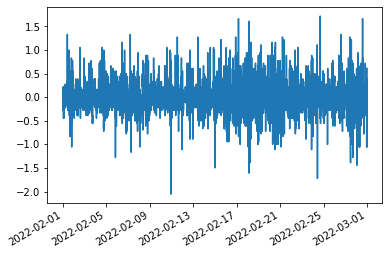

In [186]:
ts.index = pd.DatetimeIndex(ts.index.values, freq="5min")
#train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)

ts["dy"] = ts["yy"].diff(1)
ts["dy"].plot()
plt.show()


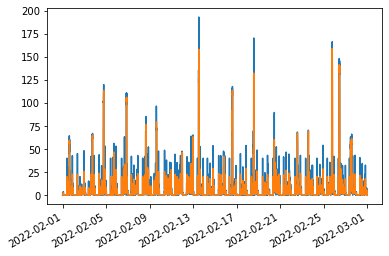

In [201]:
ts["A"] = ts["a"].ewm(halflife='5 min', times=pd.DatetimeIndex(ts.index)).mean()
ts.a.plot()
ts.A.plot()
plt.show()
#ts.describe()


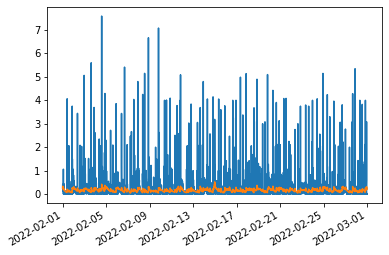

,y,a,b,c,h,yy,dy,B
count,7957.000000,8064.000000,8064.000000,8064.000000,3066.000000,8064.000000,8063.000000,8064.000000
mean,6.335716,5.135185,0.162712,0.606647,68.751931,6.340375,-0.000633,0.162680
std,1.785341,16.261032,0.473934,4.299443,16.504785,1.786439,0.289426,0.060509
min,2.164790,0.000000,0.000000,0.000000,41.000000,2.164790,-2.053780,0.043988
25%,4.995670,0.000000,0.000000,0.000000,58.500000,4.995670,-0.166520,0.115482
50%,6.050320,0.813500,0.063532,0.000000,66.000000,6.050320,0.000000,0.155945
75%,7.493510,2.853500,0.119538,0.000000,73.500000,7.493510,0.111020,0.201714
max,12.655700,192.893043,7.592103,60.000000,168.500000,12.655700,1.720730,0.520829


In [187]:
ts["B"] = ts["b"].ewm(halflife='2 hours', times=pd.DatetimeIndex(ts.index)).mean()
ts.b.plot()
ts.B.plot()
plt.show()
#ts.describe()


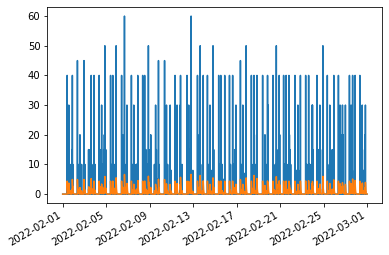

In [202]:
ts["C"] = ts["c"].ewm(halflife='30 min', times=pd.DatetimeIndex(ts.index)).mean()
ts.c.plot()
ts.C.plot()
plt.show()
#ts.describe()


In [188]:
ts["night"] = True 
ts.loc[ts.between_time('06:00','23:59').index,"night"] = False
ts.head()


,y,a,b,c,h,yy,dy,B,night
2022-02-01 00:03:13,10.6019,0.374,0.257472,0.0,57.6567,10.6019,NaN,0.257472,True
2022-02-01 00:08:13,10.6019,0.897,0.407472,0.0,55.0000,10.6019,0.0000,0.333555,True
2022-02-01 00:13:13,10.6574,1.427,0.307472,0.0,57.0000,10.6574,0.0555,0.324609,True
2022-02-01 00:18:13,10.5464,0.326,0.307472,0.0,57.0000,10.5464,-0.1110,0.320137,True
2022-02-01 00:23:13,10.5464,0.984,0.257472,0.0,NaN,10.5464,0.0000,0.306870,True


In [189]:
ts["hypo"] = ts["yy"] < 4
ts.hypo.sum()


495

In [190]:
ts["dips"] = ts.hypo & ts.night
ts.dips.sum()


133

In [191]:
ts["twos"] = False
ts.loc[ts.index[1:], "twos"] = ts.dips.values[1:] & ts.dips.values[:-1]
ts.twos.sum()


124

In [192]:
ts["tres"] = False
ts.loc[ts.index[1:-1], "tres"] = ts.dips.values[:-2] & ts.dips.values[1:-1] & ts.dips.values[2:]
ts.tres.sum()


115

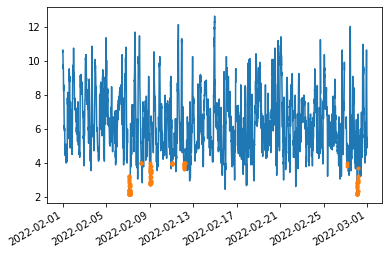

In [193]:
ts["y"].plot()
plt.plot(ts.loc[ts.dips, "y"],'.')
plt.show()


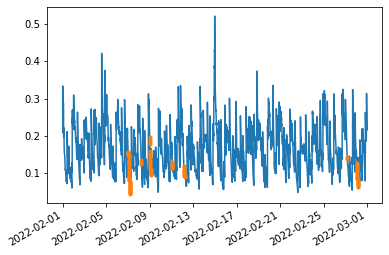

In [194]:
ts.B.plot()
plt.plot(ts.loc[ts.dips, "B"],'.')
plt.show()


In [195]:
ts["fp"] = (ts.B < 0.2) & ts.dips
ts["tp"] = (ts.B > 0.2) & ts.dips
ts.fp.sum(), ts.tp.sum()


(133, 0)

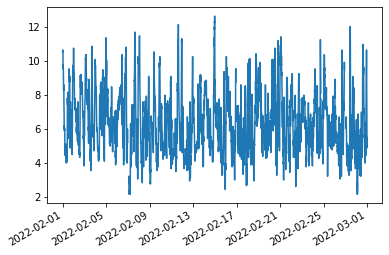

In [196]:
ts["y"].plot()
plt.plot(ts.loc[ts.tp, "y"],'.')
plt.show()


In [203]:
ts.to_csv("simple_" + filename)


In [197]:
filename

'ah78_month.csv'

In [96]:
import statsmodels.api as sm


In [99]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(ts["yy"].values, trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8064
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -62.851
Date:                Thu, 05 May 2022   AIC                            133.702
Time:                        09:24:16   BIC                            161.683
Sample:                             0   HQIC                           143.276
                               - 8064                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1319      0.015      8.844      0.000       0.103       0.161
ar.L1          0.9793      0.002    463.168      0.000       0.975       0.983
ma.L1          0.4996      0.006     78.588      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [178]:
mod = sm.tsa.statespace.SARIMAX(ts["yy"], exog=ts[["a","b","c"]], order=(2,0,2), trend='c')
fit_res = mod.fit(disp=False, maxiter=250)
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8064
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -62.851
Date:                Thu, 05 May 2022   AIC                            133.702
Time:                        10:16:13   BIC                            161.683
Sample:                             0   HQIC                           143.276
                               - 8064                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1319      0.015      8.844      0.000       0.103       0.161
ar.L1          0.9793      0.002    463.168      0.000       0.975       0.983
ma.L1          0.4996      0.006     78.588      0.0

In [179]:
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [180]:
predict.predicted_mean.shape

(8064,)

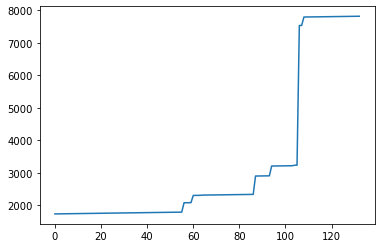

In [181]:
fp_list = [i for i in range(len(ts.fp)) if ts.fp.iloc[i]]

plt.plot(fp_list)
plt.show()


In [182]:
j = fp_list[108]

In [183]:
predict_dy = res.get_prediction(dynamic=j)
predict_dy_ci = predict_dy.conf_int()


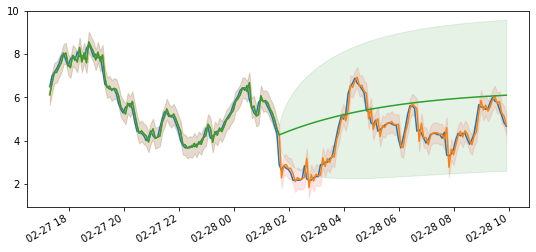

In [184]:
fig, ax = plt.subplots(figsize=(9,4))
ts.iloc[j-100:j+100]["yy"].plot()

plt.plot(ts.index[j-100:j+100], predict.predicted_mean[j-100:j+100])
ci = predict_ci
ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='r', alpha=0.1)

plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
ci = predict_dy_ci
ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.show()

In [94]:
#ssm = sm.tsa.statespace.MLEModel(endog = ts.yy.values, exog = ts[["a","b","c"]].values, k_states=1)
#ssm.fit()

class SSM(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, exog):
        # Initialize the state space model
        super(SSM, self).__init__(endog=endog, exog=exog, k_states=4, 
                                  #k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1,0,0,0]
        self['transition'] = [[1,1,1,1],[0,1,0,0][0,0,1,0],[0,0,0,1]]
        self['selection', 0, 0] = 1

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(SSM, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,1]  # these are very simple


NotImplementedError: 

NotImplementedError: 